In [303]:
from Clough_Toucher_derivation import *
import igl
import meshio as mio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import subprocess


In [304]:
def f0(x, y):
    return 1

def d0(x, y):
    return np.array([0, 0])

def f1(x, y):
    return x

def d1(x, y):
    return np.array([1, 0])

def f2(x, y):
    return x ** 2

def d2(x, y):
    return np.array([2 * x, 0])

def f3(x, y):
    return x ** 3

def d3(x, y):
    return np.array([3 * x * x, 0])

In [305]:
def build_boundary_data(_f, _d, _uv, _f_uv):
    boundary_data = []

    for fid in range(_f_uv.shape[0]):
        fv = _f_uv[fid]
        v0 = _uv[fv[0]]
        v1 = _uv[fv[1]]
        v2 = _uv[fv[2]]
        m0 = (v0 + v1) / 2.0
        m1 = (v1 + v2) / 2.0
        m2 = (v2 + v0) / 2.0

        e01 = v1 - v0
        e12 = v2 - v1
        e20 = v0 - v2

        em0 = v2 - m0
        em1 = v0 - m1
        em2 = v1 - m2

        f0 = _f(v0[0], v0[1])
        f1 = _f(v1[0], v1[1])
        f2 = _f(v2[0], v2[1])
        # print (f0)

        d0 = _d(v0[0], v0[1])
        d1 = _d(v1[0], v1[1])
        d2 = _d(v2[0], v2[1])
        # print(d0)
        
        dm0 = _d(m0[0], m0[1])
        dm1 = _d(m1[0], m1[1])
        dm2 = _d(m2[0], m2[1])

        d01 = d0 @ e01
        d10 = d1 @ (-e01)
        d12 = d1 @ e12
        d21 = d2 @ (-e12)
        d20 = d2 @ e20
        d02 = d0 @ (-e20)

        dm01 = dm0 @ em0
        dm12 = dm1 @ em1
        dm20 = dm2 @ em2

        bd = [f0,f1,f2, d01, d10, d12, d21, d20, d02, dm01, dm12, dm20]
        boundary_data.append(bd)

    print(len(boundary_data))
    return boundary_data

In [306]:
def generate_boundary_data(f, d, filename, uv, f_uv):
    f1_bd = build_boundary_data(f, d, uv, f_uv)
    with open(filename, "w") as file:
        for line in f1_bd:
            for value in line:
                file.write("{} ".format(value))
            file.write("\n")

def check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file):
    ct_interpolants = []
    with open(ct_interp_file, "r") as file:
        for line in file:
            value = float(line.split()[0])
            ct_interpolants.append(value)
    ct_interpolants = np.array(ct_interpolants)

    interior_matix = np.loadtxt(interior_file) 
    edge_end_point_matrix = np.loadtxt(endpoint_file) 
    edge_mid_point_matrix = np.loadtxt(midpoint_file) 

    r1 = interior_matix @ ct_interpolants
    r2 = edge_end_point_matrix @ ct_interpolants
    r3 = edge_mid_point_matrix @ ct_interpolants

    print("interior constraint max: ", np.max(np.abs(r1)))
    print("interior constraint avg: ", np.average(np.abs(r1)))
    print("edge endpoint constraint max: ", np.max(np.abs(r2)))
    print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
    print("edge midpoint constraint max: ", np.max(np.abs(r3)))
    print("edge midpoint constraint avg: ", np.average(np.abs(r3)))

    print(r3)

def get_P_G2E_mul_nodes(p_g2e_file, ct_interp_file):
    ct_interpolants = []
    with open(ct_interp_file, "r") as file:
        for line in file:
            value = float(line.split()[0])
            ct_interpolants.append(value)
    ct_interpolants = np.array(ct_interpolants)

    p_g2e = np.loadtxt(p_g2e_file)

    values = p_g2e @ ct_interpolants

    print(values)

def plot_ct_interpolant(ct_interp_file, ct_uv_file, f):
    ct_interpolants = []
    with open(ct_interp_file, "r") as file:
        for line in file:
            value = float(line.split()[0])
            ct_interpolants.append(value)
    ct_interpolants = np.array(ct_interpolants)

    ct_interpolants_uvs = []
    with open(ct_uv_file, "r") as file:
        for line in file:
            s = line.split()
            ct_interpolants_uvs.append([float(s[0]), float(s[1])])
    ct_interpolants_uvs = np.array(ct_interpolants_uvs)
    
    # Create a grid of x and y values
    X = ct_interpolants_uvs[:, 0]
    Y = ct_interpolants_uvs[:, 1]

    # get interpolants
    Z = ct_interpolants

    # compute real function values
    Z_real = []
    for i in range(X.shape[0]):
        Z_real.append(f(X[i], Y[i]))
    Z_real = np.array(Z_real)

    print("Z - Z_real max:", np.max(np.abs(Z-Z_real)))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the values
    ax.scatter(X, Y, Z, c = 'b', marker='o')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()

In [406]:
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'

# mesh_file = "test_two_triangles.obj"
mesh_file = "test_eight_triangles.obj"
# mesh_file = "test_three_triangles.obj"
v, uv, _, f, f_uv, _ = igl.read_obj(build_path + mesh_file)

In [407]:
# f1 d1
boundary_data_file = 'f1_boundary_data.txt'
output_name = "f1"

generate_boundary_data(f1, d1, "../../build/" + boundary_data_file, uv, f_uv)
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'
command = build_path + 'bin/generate_cubic_surface --input ' + build_path + mesh_file + ' -o ' + build_path + output_name + ' --boundary-data ' + build_path + boundary_data_file
subprocess.run(command.split(" "))

10
#Cone: 0
CHOLMOD warning: matrix not positive definite. file: /Users/jiachengdai/Desktop/algebraic-contours/build/_deps/suitesparse-src/CHOLMOD/Supernodal/t_cholmod_super_numeric.c line: 911
70 142
70 142
------------------------
edge 0 2
v0 v1 v2: 0  2  3
v0' v1' v2': 2  0  1
T: 0 2 3
T': 0 1 2
u_01: 1 1
u_02: 0 1
u_12: -1  0
u_01_prime: -1 -1
u_02_prime:  0 -1
u_12_prime: 1 0
m_01: -0.5 0.5
m_01': 0.5 -0.5
u_01_prep: -1 1
u_01_prep_prime': 1 -1
m_01.dot(u_01.normalized()) / u_01.norm(): 0
m_01_prime.dot(u_01_prime.normalized()) / u_01_prime.norm(): 0
g_M:       0       0       0       0 1.41421
g_M_prime:       0       0       0       0 1.41421
C_dM:
      0       0       0       0 1.41421       0       0       0       0 1.41421
T local id for v0 v1: 0 1
T' local id for v0' v1': 2 0
T P_dM indices: 0 1 3 4 9 
T' P_dM indices: 2 0 7 8 11 
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0

CompletedProcess(args=['/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface', '--input', '/Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj', '-o', '/Users/jiachengdai/Desktop/algebraic-contours/build/f1', '--boundary-data', '/Users/jiachengdai/Desktop/algebraic-contours/build/f1_boundary_data.txt'], returncode=0)

In [408]:
command

'/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface --input /Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj -o /Users/jiachengdai/Desktop/algebraic-contours/build/f1 --boundary-data /Users/jiachengdai/Desktop/algebraic-contours/build/f1_boundary_data.txt'

In [409]:
ct_interp_file = "../../build/f1_function_values_from_lagrange_nodes.txt"
ct_uv_file = "../../build/f1_function_values_from_lagrange_nodes_uvs.txt"
interior_file = '../../build/f1_interior_constraint_matrix.txt'
endpoint_file = '../../build/f1_edge_endpoint_constraint_matrix.txt'
midpoint_file = '../../build/f1_edge_midpoint_constraint_matrix.txt'
check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file)
# plot_ct_interpolant(ct_interp_file, ct_uv_file, f1)

interior constraint max:  1.5543122344752192e-15
interior constraint avg:  2.8102520310824275e-16
edge endpoint constraint max:  1.4210854715202004e-14
edge endpoint constraint avg:  2.76249611421436e-15
edge midpoint constraint max:  4.263256414560601e-14
edge midpoint constraint avg:  7.288287620480439e-15
[-1.06581410e-14  2.88657986e-15  0.00000000e+00 -1.06581410e-14
  1.77635684e-15  0.00000000e+00 -1.06581410e-14  4.26325641e-14
 -4.44089210e-15  0.00000000e+00 -2.13162821e-14  2.66453526e-15
  8.88178420e-15 -1.49880108e-15  0.00000000e+00  5.82867088e-15
  0.00000000e+00]


In [410]:
# f2
boundary_data_file = 'f2_boundary_data.txt'
output_name = "f2"

generate_boundary_data(f2, d2, "../../build/" + boundary_data_file, uv, f_uv)
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'
command = build_path + 'bin/generate_cubic_surface --input ' + build_path + mesh_file + ' -o ' + build_path + output_name + ' --boundary-data ' + build_path + boundary_data_file
subprocess.run(command.split(" "))

10
#Cone: 0
CHOLMOD warning: matrix not positive definite. file: /Users/jiachengdai/Desktop/algebraic-contours/build/_deps/suitesparse-src/CHOLMOD/Supernodal/t_cholmod_super_numeric.c line: 911
70 142
70 142
------------------------
edge 0 2
v0 v1 v2: 0  2  3
v0' v1' v2': 2  0  1
T: 0 2 3
T': 0 1 2
u_01: 1 1
u_02: 0 1
u_12: -1  0
u_01_prime: -1 -1
u_02_prime:  0 -1
u_12_prime: 1 0
m_01: -0.5 0.5
m_01': 0.5 -0.5
u_01_prep: -1 1
u_01_prep_prime': 1 -1
m_01.dot(u_01.normalized()) / u_01.norm(): 0
m_01_prime.dot(u_01_prime.normalized()) / u_01_prime.norm(): 0
g_M:       0       0       0       0 1.41421
g_M_prime:       0       0       0       0 1.41421
C_dM:
      0       0       0       0 1.41421       0       0       0       0 1.41421
T local id for v0 v1: 0 1
T' local id for v0' v1': 2 0
T P_dM indices: 0 1 3 4 9 
T' P_dM indices: 2 0 7 8 11 
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0

CompletedProcess(args=['/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface', '--input', '/Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj', '-o', '/Users/jiachengdai/Desktop/algebraic-contours/build/f2', '--boundary-data', '/Users/jiachengdai/Desktop/algebraic-contours/build/f2_boundary_data.txt'], returncode=0)

In [411]:
ct_interp_file = "../../build/f2_function_values_from_lagrange_nodes.txt"
ct_uv_file = "../../build/f2_function_values_from_lagrange_nodes_uvs.txt"
interior_file = '../../build/f2_interior_constraint_matrix.txt'
endpoint_file = '../../build/f2_edge_endpoint_constraint_matrix.txt'
midpoint_file = '../../build/f2_edge_midpoint_constraint_matrix.txt'
check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file)
# plot_ct_interpolant(ct_interp_file, ct_uv_file, f2)

interior constraint max:  2.6645352591003757e-15
interior constraint avg:  3.487785457271083e-16
edge endpoint constraint max:  5.684341886080802e-14
edge endpoint constraint avg:  4.884981308350689e-15
edge midpoint constraint max:  4.973799150320701e-14
edge midpoint constraint avg:  7.418902093965752e-15
[-4.44089210e-15  3.33066907e-15  0.00000000e+00  7.10542736e-15
  9.76996262e-15  0.00000000e+00 -3.19744231e-14 -7.10542736e-15
  1.77635684e-15  0.00000000e+00 -4.97379915e-14  8.88178420e-16
 -2.66453526e-15 -5.55111512e-16  0.00000000e+00 -2.88657986e-15
  3.88578059e-15]


In [412]:
# f3
boundary_data_file = 'f3_boundary_data.txt'
output_name = "f3"

generate_boundary_data(f3, d3, "../../build/" + boundary_data_file, uv, f_uv)
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'
command = build_path + 'bin/generate_cubic_surface --input ' + build_path + mesh_file + ' -o ' + build_path + output_name + ' --boundary-data ' + build_path + boundary_data_file
subprocess.run(command.split(" "))

10
#Cone: 0
CHOLMOD warning: matrix not positive definite. file: /Users/jiachengdai/Desktop/algebraic-contours/build/_deps/suitesparse-src/CHOLMOD/Supernodal/t_cholmod_super_numeric.c line: 911
70 142
70 142
------------------------
edge 0 2
v0 v1 v2: 0  2  3
v0' v1' v2': 2  0  1
T: 0 2 3
T': 0 1 2
u_01: 1 1
u_02: 0 1
u_12: -1  0
u_01_prime: -1 -1
u_02_prime:  0 -1
u_12_prime: 1 0
m_01: -0.5 0.5
m_01': 0.5 -0.5
u_01_prep: -1 1
u_01_prep_prime': 1 -1
m_01.dot(u_01.normalized()) / u_01.norm(): 0
m_01_prime.dot(u_01_prime.normalized()) / u_01_prime.norm(): 0
g_M:       0       0       0       0 1.41421
g_M_prime:       0       0       0       0 1.41421
C_dM:
      0       0       0       0 1.41421       0       0       0       0 1.41421
T local id for v0 v1: 0 1
T' local id for v0' v1': 2 0
T P_dM indices: 0 1 3 4 9 
T' P_dM indices: 2 0 7 8 11 
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0

CompletedProcess(args=['/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface', '--input', '/Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj', '-o', '/Users/jiachengdai/Desktop/algebraic-contours/build/f3', '--boundary-data', '/Users/jiachengdai/Desktop/algebraic-contours/build/f3_boundary_data.txt'], returncode=0)

interior constraint max:  4.524158825347513e-15
interior constraint avg:  5.339602767876325e-16
edge endpoint constraint max:  2.842170943040401e-14
edge endpoint constraint avg:  3.24413698519145e-15
edge midpoint constraint max:  1.490711984999857
edge midpoint constraint avg:  0.33763059114198096
[-4.44089210e-15 -2.50000000e-01  0.00000000e+00  1.49071198e+00
 -8.88178420e-16  0.00000000e+00  4.71404521e-01  1.86338998e-01
  2.50000000e-01  0.00000000e+00  4.71404521e-01 -1.49071198e+00
 -4.71404521e-01 -1.38777878e-16  0.00000000e+00 -4.71404521e-01
 -1.86338998e-01]
Z - Z_real max: 3.2263466668513985e-05


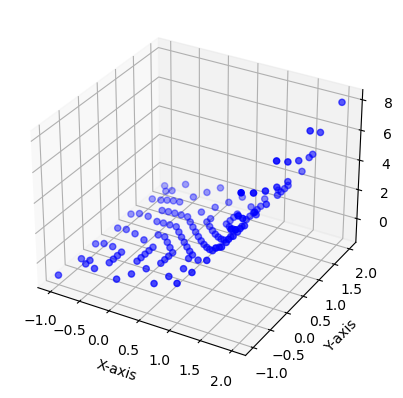

In [413]:
ct_interp_file = "../../build/f3_function_values_from_lagrange_nodes.txt"
ct_uv_file = "../../build/f3_function_values_from_lagrange_nodes_uvs.txt"
interior_file = '../../build/f3_interior_constraint_matrix.txt'
endpoint_file = '../../build/f3_edge_endpoint_constraint_matrix.txt'
midpoint_file = '../../build/f3_edge_midpoint_constraint_matrix.txt'
check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file)
plot_ct_interpolant(ct_interp_file, ct_uv_file, f3)

In [48]:
# test on tet mesh

interior_matix = np.loadtxt('../../build/icosphere_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/icosphere_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/icosphere_edge_midpoint_constraint_matrix.txt')

ico_sphere_mesh = mio.read("../../build/icosphere_from_lagrange_nodes.msh")
ico_points = ico_sphere_mesh.points

local2global = []
idx = 0
# with open("../../build/icosphere_surface_tri_to_tet_v_map.txt", "r") as file:
#     for line in file:
#         local2global.append(int(line))
#         idx += 1

with open("../../build/icosphere_surface_correct_tri_to_tet_v_map.txt", "r") as file:
    for line in file:
        local2global.append(int(line))
        idx += 1

tetmesh = mio.read("../../build/test_curved_high_order_tetmesh.msh")
surface_mesh = mio.read("../../build/icosphere_from_lagrange_nodes.msh")

s_points = surface_mesh.points
t_points = tetmesh.points

t_s_points = t_points[local2global]

t_s_points_2 = []
for i in local2global:
    t_s_points_2.append(t_points[i])
t_s_points_2 = np.array(t_s_points_2)

r1 = interior_matix @ ico_points
# r2 = edge_end_point_matrix @ ico_points
# r3 = edge_mid_point_matrix @ ico_points

print("interior constraint max: ", np.max(np.abs(r1)))
print("interior constraint avg: ", np.average(np.abs(r1)))
# print("edge endpoint constraint max: ", np.max(np.abs(r2)))
# print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
# print("edge midpoint constraint max: ", np.max(np.abs(r3)))
# print("edge midpoint constraint avg: ", np.average(np.abs(r3)))




interior constraint max:  2.9719339766920427e-09
interior constraint avg:  3.6683438295738295e-11


In [42]:
s_points.shape

(1730, 3)

In [43]:
t_s_points_2.shape

(1730, 3)

In [44]:
s_points - t_s_points_2

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [45]:
miss_match_cnt = 0
for i in range((s_points - t_s_points_2).shape[0]):
    if abs((s_points - t_s_points_2)[i][0]) > 1e-10:
        # print((s_points - t_s_points_2)[i])
        miss_match_cnt += 1

In [46]:
local2global = np.loadtxt("icosphere_surface_correct_tri_to_tet_v_map.txt").astype(np.int32)
A = np.loadtxt("ico_.txt")
m = mio.read("test_linear_high_order_tetmesh.msh")
v = m.points
b = -(A @ v[local2global, :])

print(A.shape)
print(local2global.shape)
print(b.shape)

with h5py.File("3dc.hdf5", 'w') as f:
    f.create_dataset("local2global", data=local2global.astype(np.int32))
    f.create_dataset("A", data=A)
    f.create_dataset("b", data=b)

0

In [50]:
interior_matix = np.loadtxt('../../build/icosphere_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/icosphere_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/icosphere_edge_midpoint_constraint_matrix.txt')

big_mesh = np.concatenate((interior_matix, edge_end_point_matrix, edge_mid_point_matrix))

In [52]:
print(interior_matix.shape)
print(edge_end_point_matrix.shape)
print(edge_mid_point_matrix.shape)
print(big_mesh.shape)

(896, 1730)
(384, 1730)
(192, 1730)
(1472, 1730)


In [58]:
import h5py

local2global = np.loadtxt("../../build/icosphere_surface_correct_tri_to_tet_v_map.txt").astype(np.int32)
A = big_mesh
m = mio.read("../../build/test_linear_high_order_tetmesh.msh")
v = m.points
b = -(A @ v[local2global, :])

print(A.shape)
print(local2global.shape)
print(b.shape)

with h5py.File("3dc.hdf5", 'w') as f:
    f.create_dataset("local2global", data=local2global.astype(np.int32))
    f.create_dataset("A", data=A)
    f.create_dataset("b", data=b)


(1472, 1730)
(1730,)
(1472, 3)


In [302]:
get_P_G2E_mul_nodes("../../build/P_G2E.txt", "../../build/f1_function_values_from_lagrange_nodes.txt")

[0.         1.         0.         0.33333333 0.66666667 0.66666667
 0.33333333 0.         0.         0.44444444 0.44444444 0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.33333333 0.66666667 0.66666667
 0.33333333 0.         0.         0.44444444 0.44444444 0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.66666667 0.33333333 0.
 0.         0.33333333 0.66666667 0.44444444 0.11111111 0.44444444
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.66666667 0.33333333 0.
 0.         0.33333333 0.66666667 0.44444444 0.11111111 0.44444444
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.     